# Финальный проект: телекоммуникации

**ОПИСАНИЕ ПРОЕКТА:**

Оператор связи «ТелеДом» хочет снизить отток клиентов и начнет предлагать промокоды тем, кто собирается отказаться от услуг. Для этого им нужна модель, предсказывающая, разорвёт ли абонент договор. Команда собрала персональные данные клиентов и информацию о тарифах. Задача — обучить модель для прогноза оттока клиентов.

Оператор предлагает два основных типа услуг:   
-  стационарную телефонную связь с возможностью подключения к нескольким линиям и интернет (через DSL или оптоволоконный кабель).   
-  дополнительно доступны: интернет-безопасность (антивирус и блокировка небезопасных сайтов), выделенная техническая поддержка, облачное хранилище для резервного копирования, стриминговое телевидение и каталог фильмов.   

Клиенты могут оплачивать услуги ежемесячно или по договору на 1–2 года, с возможностью различных способов оплаты и получения электронного чека.  

**КРИТЕРИИ ОЦЕНКИ РАБОТЫ:**

Основная метрика: AUC-ROC >= 0.85  
Дополнительная метрика: Accuracy.


**ЦЕЛЬ ПРОЕКТА:**

Разработка модели машинного обучения для прогнозирования оттока клиентов оператора связи «ТелеДом» с целью своевременного предотвращения ухода абонентов путём предложения им промокодов и специальных условий.

Эта цель включает:

Анализ данных о клиентах (персональные данные, тарифы, услуги).

Обучение модели, способной предсказать вероятность расторжения договора.

Помощь оператору в снижении оттока клиентов за счёт своевременного вмешательства.

# План работы

**Загрузка данных**

-  импортировать необходимые библиотеки и модули
-  загрузить данные
-  выполнить их первичный осмотр

**Исследовательский анализ и предобработка данных** 

-  произвести предобработку данных для каждого датафрейма
-  выполнить исследовательский анализ каждого датафрейма 

**Объединение данных**

-  объединить таблицы в один датафрейм по ключу

**Исследовательский анализ и предобработка данных объединённого датафрейма**

-  выполнить исследовательский анализ объединённого датафрейма
-  визуализировать распределения признаков 
-  провести корреляционный анализ 

**Подготовка данных**

-  подготовить данных для обучения модели
-  разделить данные на две выборки

**Обучение моделей машинного обучения**

Обучение трех моделей:

-  LGBMClassifier
-  CatBoostClassifier
-  RandomForestClassifier

Применить GridSearch для оптимизации гиперпараметров этих моделей.  
Создание пайплайна для модели LGBM.

**Выбор лучшей модели**

-  Выбрать лучшую модель
-  проверить её качество на тестовой выборке.

**Общий вывод и рекомендации заказчику**

-  сделать общий вывод по проекту и дать рекомендации для бизнеса


## Загрузка данных

### Для работы над проектом нужно импортировать необходимые библиотеки и модули.

In [1]:
!pip install -q phik
!pip install category_encoders
!pip install tabulate
!pip install imbalanced-learn
!pip install scikit-learn lightgbm

     |████████████████████████████████| 82 kB 164 kB/s eta 0:00:011
     |████████████████████████████████| 258 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.5 MB 42.2 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import lightgbm as lgb

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tabulate import tabulate

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from math import ceil
from sqlalchemy import create_engine

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

RANDOM_STATE = 100225

### Считываю CSV-файлы с данными и сохраняю их в датафрейм

In [3]:
df_contract = pd.read_csv('/datasets/contract_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

**Датафрейм contract**

In [4]:
# Выводожу информацию df_contract для предварительного просмотра данных
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


**Датафрейм internet**

In [5]:
# Выводожу информацию df_internet для предварительного просмотра данных
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


**Датафрейм personal**

In [6]:
# Выводожу информацию df_personal для предварительного просмотра данных
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**Датафрейм phone**

In [7]:
# Выводожу информацию df_phone для предварительного просмотра данных
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Вывод:**

Загрузка датасетов завершена успешно.  Их количество соответствует заданным условиям проекта. Следующим этапом будет проведена предобработка данных и исследовательский анализ для каждого из датасетов. Это позволит получить более глубокое понимание о данных и выявить ключевые особенности, которые могут быть полезны для дальнейшего анализа и моделирования.

## Исследовательский анализ и предобработка данных

In [8]:
# напишу функцию для получения основной информации о датасетах
def get_info(df, name_of_df):
    display(df.head())
    print(f"\nТаблица датасета '{name_of_df}':\n")
    print('Размер датасета:', df.shape)
    print('\nТипы данных:')
    display(df.dtypes)
    print('\nКолличество пропущенных значений:')
    display(df.isna().sum())
    print('\nСтатистическое описание числовых данных:')
    display(df.describe())
    print('\nКоличество дубликатов в датасете:', df.duplicated().sum())

### Датасет contract

In [9]:
get_info(df_contract, 'contract')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Таблица датасета 'contract':

Размер датасета: (7043, 8)

Типы данных:


customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object


Колличество пропущенных значений:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Статистическое описание числовых данных:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Количество дубликатов в датасете: 0


По полученной информации о датасете contract необходимо:
-  в столбце TotalCharges изменить тип данных на object вместо float.    
-  исправить информацию в столбце BeginDate, так как у всех пользователей одна и та же дата начала контракта.
-  преобразовать столбцы BeginDate и EndDate в корректный формат даты.
-  добавить новый признак для определения продолжительности договора, когда пользователь "был с нами".

In [10]:
# фильтрую информацию для строк с пустым значением в столбце 'TotalCharges' 
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [11]:
# убираю строки с пустыми значениями в столбце 'TotalCharges'.
df_contract = df_contract.loc[df_contract['TotalCharges'] != ' ']

In [12]:
# проверка результата
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Преобразование столбца TotalCharges выполнено успешно.

In [13]:
# Преобразую столбец 'TotalCharges' в тип float
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
# проверка результата
df_contract.info()
df_contract.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


(7032, 8)

Изменение типа данных произведено успешно.   
Выделяю целевой признак в отдельный столбец. Преобразую столбцы BeginDate и EndDate в корректный формат даты. 

In [14]:
df_contract.loc[df_contract['EndDate'] == 'No', 'left_company'] = 0
df_contract.loc[df_contract['EndDate'] != 'No', 'left_company'] = 1

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Отлично, получили целевую переменную!
    
</div>

In [15]:
df_contract['BeginDate'] =  df_contract['BeginDate'].apply(pd.to_datetime)

In [16]:
df_contract.EndDate = df_contract.EndDate.replace('No','2020-02-01')

In [17]:
df_contract['EndDate'] =  df_contract['EndDate'].apply(pd.to_datetime)

In [18]:
# проверка результата
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,left_company
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0


Приведение данных к нужному формату произведено успешно.  
Теперь необходимо выяснить, как долго пользователь "находится с нами" или продолжает оставаться нашим клиентом. 

In [19]:
# добавляю новый признак для определения колличества дней, когда пользователь был нашим клиентом
df_contract['Count_days'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

In [20]:
# проверка результата
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,left_company,Count_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153


Добавление признака произведено успешно.  
Теперь нам известно, сколько дней пользователь "находится с нами" или продолжает оставаться нашим клиентом.

ВЫВОД:
Подготовка и изучение данных являются важнейшими этапами в реализации проекта и ключевыми моментами в любом анализе. В процессе ичучения данных о датасете 'contract' можно сделать следующие выводы:  

Датасет содержит 7043 записи и 8 столбцов. Объём выборки считается значительным, что позволяет рассчитывать на репрезентативность результатов и достоверность выводов.  
Пропуски и дублиуаты в датасете отсутствуют, это говорит о том, что данные готовы для дальнейшего анализа.  
Изменен тип данных в столбце TotalCharges к типу данных object.  
Приведено значение столбца BeginDate к правильным датам начала договоров.  
Выделен целевой признак в отдельный столбец и преобразованы столбцы BeginDate и EndDate в корректный формат даты.   
Определен период, сколько времени наш клиент "был с нами" или продолжает быть нашим клиентом, для этого добавлен новый признак Count_days.  
Выполненные преобразования подготовили данные для дальнейшего анализа.

### Датасет personal

In [22]:
get_info(df_personal, 'personal')

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Таблица датасета 'personal':

Размер датасета: (7043, 5)

Типы данных:


customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object


Колличество пропущенных значений:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


Статистическое описание числовых данных:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Количество дубликатов в датасете: 0


По полученной информации о датасете personal необходимо:  
-  привести значения в столбцах 'Partner' и 'Dependenrs'  к булевому значению

In [23]:
# Изменение значений столбца 'Partner' к булевому значению
df_personal.loc[df_personal['Partner'] == 'Yes', 'Partner'] = 1
df_personal.loc[df_personal['Partner'] == 'No', 'Partner'] = 0

# Изменение значений столбца 'Dependents' к булевому значению
df_personal.loc[df_personal['Dependents'] == 'Yes', 'Dependents'] = 1
df_personal.loc[df_personal['Dependents'] == 'No', 'Dependents'] = 0

# проверка результата
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


Значения столбцов  'Partner' и 'Dependenrs' приведены к булевому значению успешно.

ВЫВОД:
Подготовка и изучение данных являются важнейшими этапами в реализации проекта и ключевыми моментами в любом анализе. В процессе ичучения данных о датасете 'personal' можно сделать следующие выводы:  

Датасет содержит 7043 записи и 5 столбцов. Объём выборки считается значительным, что позволяет рассчитывать на репрезентативность результатов и достоверность выводов.  
Пропуски и дублиуаты в датасете отсутствуют, это говорит о том, что данные готовы для дальнейшего анализа.     
Значения столбцов 'Partner' и 'Dependenrs' приведены к булевому значению.  
Выполненные преобразования подготовили данные для дальнейшего анализа.

### Датасет internet

In [24]:
get_info(df_internet, 'internet')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Таблица датасета 'internet':

Размер датасета: (5517, 8)

Типы данных:


customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object


Колличество пропущенных значений:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


Статистическое описание числовых данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0945-TSONX,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Количество дубликатов в датасете: 0


ВЫВОД:
Подготовка и изучение данных являются важнейшими этапами в реализации проекта и ключевыми моментами в любом анализе. В процессе ичучения данных о датасете 'internet' можно сделать следующие выводы:  

Датасет содержит 5517 записей и 8 столбцов. Объём выборки считается значительным, что позволяет рассчитывать на репрезентативность результатов и достоверность выводов.  
Пропуски и дублиуаты в датасете отсутствуют, это говорит о том, что данные готовы для дальнейшего анализа.     
Выполненные преобразования подготовили данные для дальнейшего анализа.

### Датасет phone

In [26]:
get_info(df_phone, 'phone')

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Таблица датасета 'phone':

Размер датасета: (6361, 2)

Типы данных:


customerID       object
MultipleLines    object
dtype: object


Колличество пропущенных значений:


customerID       0
MultipleLines    0
dtype: int64


Статистическое описание числовых данных:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2368-GAKKQ,No
freq,1,3390



Количество дубликатов в датасете: 0


**ВЫВОД по разделу: Исследовательский анализ и предобработка данных**

Подготовка и изучение данных являются важнейшими этапами в реализации проекта и ключевыми моментами в любом анализе. В процессе ичучения данных о датасете 'internet' можно сделать следующие выводы:  

Датасет содержит 6361 запись и 2 столбца. Объём выборки считается значительным, что позволяет рассчитывать на репрезентативность результатов и достоверность выводов.  
Пропуски и дубликаты в датасете отсутствуют, это говорит о том, что данные готовы для дальнейшего анализа.     
Выполненные преобразования подготовили данные для дальнейшего анализа.

## Объединение данных

In [28]:
# Объединение датафреймов по ключу 'customerID'
df = df_contract.merge(df_personal, on='customerID')
df = df.merge(df_internet, how='left', on='customerID')
df = df.merge(df_phone, how='left', on='customerID')

In [29]:
# Проверка количества уникальных пользователей
print('Количество уникальных пользователей:', len(df['customerID'].unique()))
print('Размер датафрейма:', df.shape[0])

Количество уникальных пользователей: 7032
Размер датафрейма: 7032


In [30]:
print('Столбцы объединенного датафрейма:\n')
display(df.columns)
# проверка результата
print()
display(df.head())

Столбцы объединенного датафрейма:



Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'left_company',
       'Count_days', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,left_company,Count_days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31,...,1,0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0,1036,...,0,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123,...,0,0,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371,...,0,0,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153,...,0,0,Fiber optic,No,No,No,No,No,No,No


**ВЫВОД по разделу: Объединение данных**

Объединение таблиц по ключу 'customerID' прошло успешно, что подтверждается совпадением количества уникальных пользователей (7032) и размера итогового датафрейма (7032). Это создает надежную основу для дальнейшей работы.   
Следующим шагом будет предобработка данных, которая включает проверку пропущенных значений и преобразование типов данных, а также проведение исследовательского анализа объединённого датафрейма для выявления закономерностей и дальнейшего обучения моделей машинного обучения.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Проверка датасета на колличество пропущенных значений

In [31]:
print('Пропущенные значения объединенного датафрейма:')

df.isna().sum()

Пропущенные значения объединенного датафрейма:


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
left_company           0
Count_days             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
dtype: int64

На основе данных о пропущенных значениях в объединенном датафрейме можно сделать следующие выводы:

1. Отсутствие пропусков: Большинство полей не имеют пропущенных значений, что свидетельствует о корректности сбора данных.

2. Проблемные поля: 

   • Поля InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies имеют по 1520 пропущенных значений, что может указывать на отсутствие данных у пользователей без соответствующих услуг.

   • Поле MultipleLines содержит 680 пропущенных значений, возможно, из-за недостатка информации от пользователей.

3. Классификация: Пропуски в полях, связанных с услугами, могут быть связаны с тем, что некоторые клиенты не пользовались этими услугами.

4. Обработка пропусков: Данные пропуски заполню значением 'No'.

Так как таких пользователей было выявлено много, то их не стоит удалять из базы. Заменю пропуски значением "No".

In [33]:
df.fillna('No', inplace=True)

Но лучше оставить исходные значения Yes/No и сделать заполнение значениями No.

In [34]:
# проверка результата
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,left_company,Count_days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31,...,1,0,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0,1036,...,0,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123,...,0,0,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371,...,0,0,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153,...,0,0,Fiber optic,No,No,No,No,No,No,No


In [35]:
print('Пропущенные значения объединенного датафрейма:')
# проверка результата
df.isna().sum()

Пропущенные значения объединенного датафрейма:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
left_company        0
Count_days          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Замена пропусков произведена успешно.

### Исследовательский анализ данных

In [37]:
# напишу функцию для построения графика, отображающего долю расторгнутых договоров в зависимости от категориального признака.
def create_hist_categorical(col, rotate=0):
    sns.histplot(
        df,
        x=col,
        hue='left_company',
        multiple='fill'
    )

    plt.title(f'Доля расторгнувших по "{col}"')
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.xticks(rotation=rotate)
    plt.ylabel('Доля')

# напишу функцию для построения диаграммы для бинарных характеристик.
def binary_pie(col, title_name):
    col_count = df.pivot_table(index=col, values='gender', aggfunc='count').reset_index()
    col_count

    col_count.loc[col_count[col] == 0, col] = 'Нет'
    col_count.loc[col_count[col] == 1, col] = 'Да'

    plt.figure(figsize=(3, 3))

    plt.pie(
        col_count['gender'],
        labels=col_count[col],
        autopct='%1.1f%%'
    )

    plt.title(title_name, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

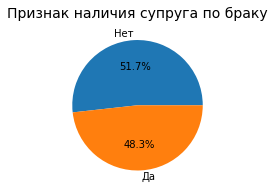

In [38]:
# построю диаграмму признака наличия супруга по браку.
binary_pie('Partner', 'Признак наличия супруга по браку')

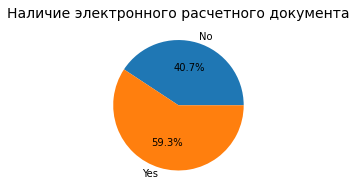

In [39]:
# построю диаграмму признака наличия электронного расчетного документа
binary_pie('PaperlessBilling', 'Наличие электронного расчетного документа')

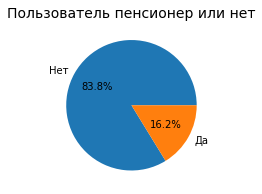

In [40]:
# построю диаграмму наличие признака пенсионер или нет
binary_pie('SeniorCitizen', 'Пользователь пенсионер или нет')

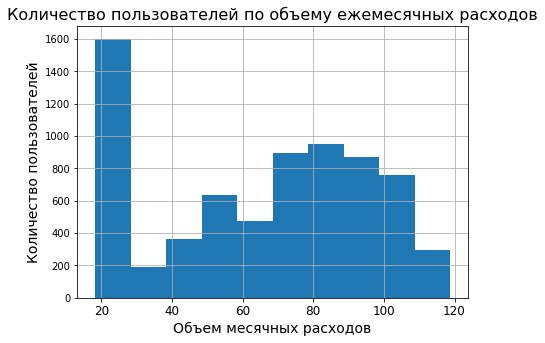

In [41]:
# построю гистограмму количества пользователей в зависимости от суммы их ежемесячных расходов
df.hist('MonthlyCharges', figsize=(7, 5))

plt.title('Количество пользователей по объему ежемесячных расходов', fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel('Объем месячных расходов', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.show()

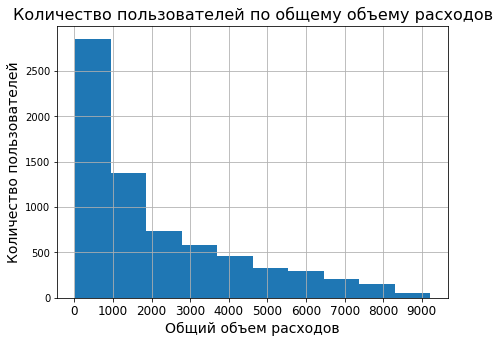

In [42]:
# построю гистограмму количества пользователей по общему объему расходов
df.hist('TotalCharges', figsize=(7, 5))

plt.title('Количество пользователей по общему объему расходов', fontsize=16)
plt.xticks(np.arange(0, 9001, 1000), fontsize=12)
plt.xlabel('Общий объем расходов', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)

plt.show()

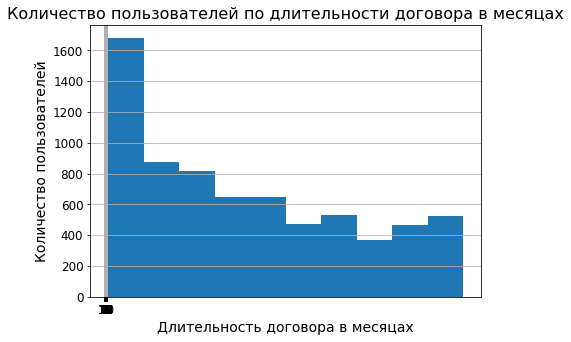

In [43]:
# строю гистограмму количества пользователей по длительности договора 
df.hist('Count_days', figsize=(7, 5))

plt.title('Количество пользователей по длительности договора в месяцах', fontsize=16)
plt.xlabel('Длительность договора в месяцах', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.xticks(np.arange(0, 21, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

ВЫВОД:

Анализируя каждый из упомянутых выше параметров, можно выделить следующее:    
Почти равное количество людей состоит/не состоит в браке: 48,3% и 51,7% соответственно.  
Большинство пользователей предпочитают получать счета в электронном виде, что составляет 59,3%.   
Пенсионеры составляют лишь около 16,2% от общего числа пользователей.  
Большинство пользователей тратят не более 1000 у.е. в общем объеме расходов.

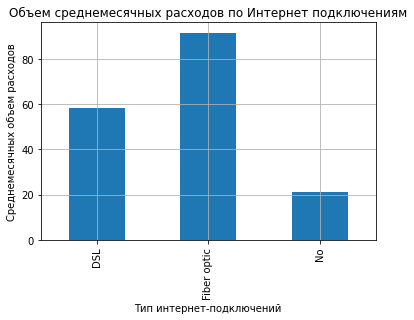

In [44]:
# построю диаграмму всех среднемесячных расходов на Интернет-подключения
internet_charges = df.pivot_table(index='InternetService', values='MonthlyCharges', aggfunc='mean').reset_index()

internet_charges.plot(
    x='InternetService',
    y='MonthlyCharges',
    kind='bar',
    title='Объем среднемесячных расходов по Интернет подключениям',
    xlabel='Тип интернет-подключений',
    ylabel='Среднемесячных объем расходов',
    grid=True,
    legend=False
)

plt.show()

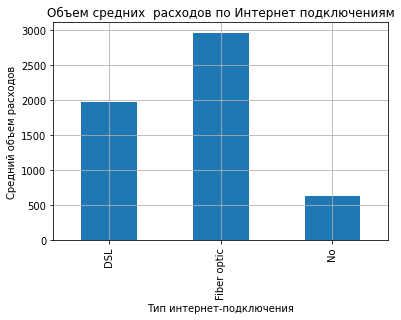

In [45]:
# построю диаграмму всех средних расходов на Интернет-подключения
total_charges = df.pivot_table(index='InternetService', values='TotalCharges', aggfunc='mean').reset_index()

total_charges.plot(
    x='InternetService',
    y='TotalCharges',
    kind='bar',
    title='Объем средних  расходов по Интернет подключениям',
    xlabel='Тип интернет-подключения',
    ylabel='Средний объем расходов',
    grid=True,
    legend=False
)

plt.show()

ВЫВОД:

Из последних двух графиков видно, что тип подключения влияет на решение пользователя о расторжении договора. Это, вероятно, связано с ценой услуг, предлагаемых телекоммуникационной компанией.   
На втором графике показано, что среднемесячные расходы пользователей с подключением «Оптоволокно» значительно выше, составляя 80 у.е., в то время как клиенты с подключением DSL тратят 60 у.е. Пользователи, не имеющие доступа к Интернету, в среднем платят около 20 у.е. В общем объеме расходов на первом месте пользователи с оптоволоконным подключением, которые тратят больше всего, на втором месте пользователи DSL, а затем те, кто не подключен к интернет-услугам.

In [46]:
print('Количество пользователей в зависимости от срока действия договора.:')
df['Count_days'].astype('int').value_counts()

Количество пользователей в зависимости от срока действия договора.:


2191    265
153     249
92      243
31      236
123     236
       ... 
789       1
305       1
121       1
2068      1
28        1
Name: Count_days, Length: 250, dtype: int64

In [47]:
# проверка результата
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,left_company,Count_days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31,...,1,0,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0,1036,...,0,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123,...,0,0,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371,...,0,0,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153,...,0,0,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,0.0,730,...,1,1,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7028,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,0.0,2191,...,1,1,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7029,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,0.0,337,...,1,1,DSL,Yes,No,No,No,No,No,No
7030,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,0.0,215,...,1,0,Fiber optic,No,No,No,No,No,No,Yes


 Построю гистограммы sns.histplot для категориальных признаков в разрезе 'left_company'.  

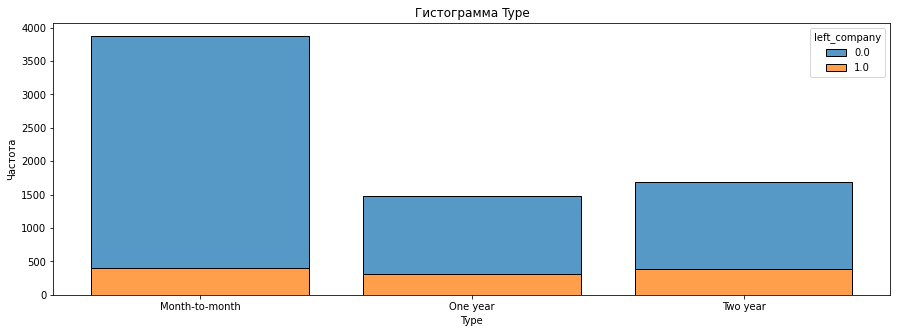

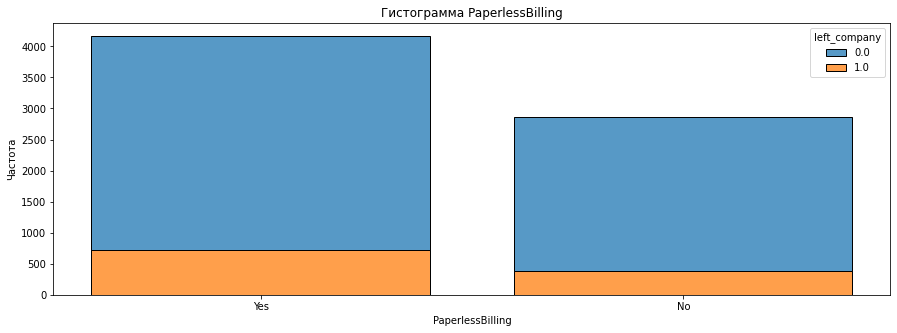

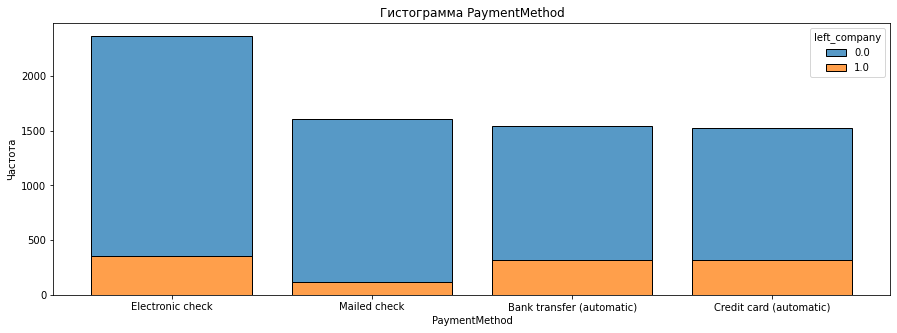

In [48]:
# Построение гистограмм
for i in ['Type','PaperlessBilling','PaymentMethod']:
    plt.figure(figsize=(15,5))
    sns.histplot(data=df, x=i, hue='left_company', multiple="stack", shrink=.8)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гистограмма {i}')
    plt.show()

Выводы по гистограммам:

1. Тип контракта Type: Наибольшее количество клиентов предпочитает месячные контракты, что указывает на их стремление к гибкости. Однако этот тип контракта также связан с высоким уровнем ухода, что может свидетельствовать о меньшей лояльности к клиентам. Долгосрочные контракты (One year, Two year) показывают более низкий уровень ухода, предполагая большую лояльность.

2. Стратегии удержания: Для снижения уровня ухода среди клиентов с месячными контрактами компании стоит рассмотреть внедрение программ лояльности или предложений для перевода на долгосрочные контракты.

3. Безбумажное выставление счетов PaperlessBilling: Клиенты, использующие безбумажное выставление счетов, имеют более высокий уровень ухода, что может указывать на их меньшую привязанность к компании. Необходимо учитывать дополнительные факторы, влияющие на отток.

4. Способы оплаты PaymentMethod: Электронный чек является самым популярным способом оплаты, но также имеет высокий уровень ухода. Автоматические способы оплаты (банковский перевод и кредитная карта) связаны с меньшим уровнем оттока, что может указывать на большую удовлетворенность клиентов.

В целом, анализ данных показывает необходимость улучшения программ удержания клиентов и оценки факторов, влияющих на их уход.

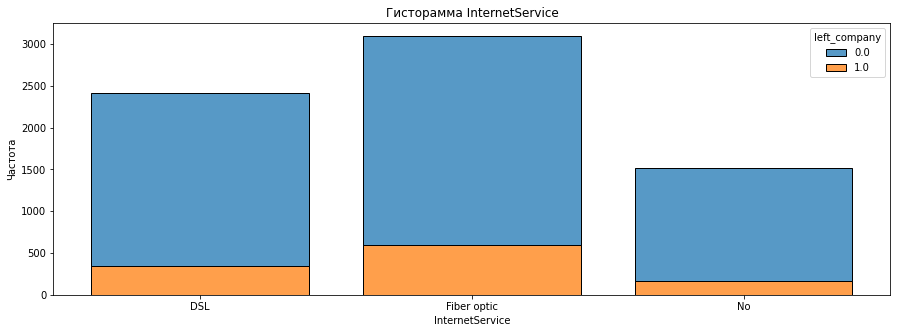

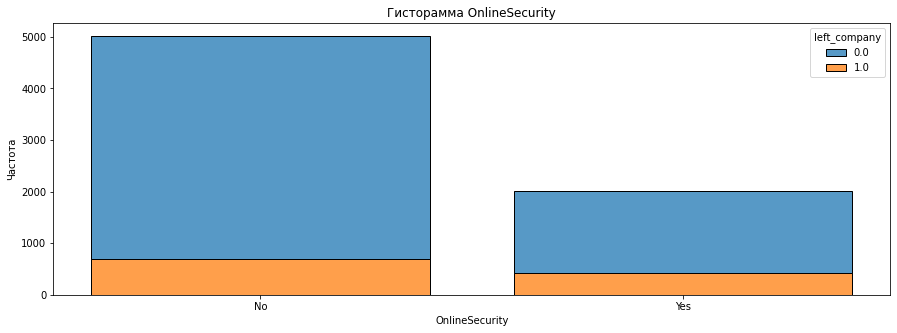

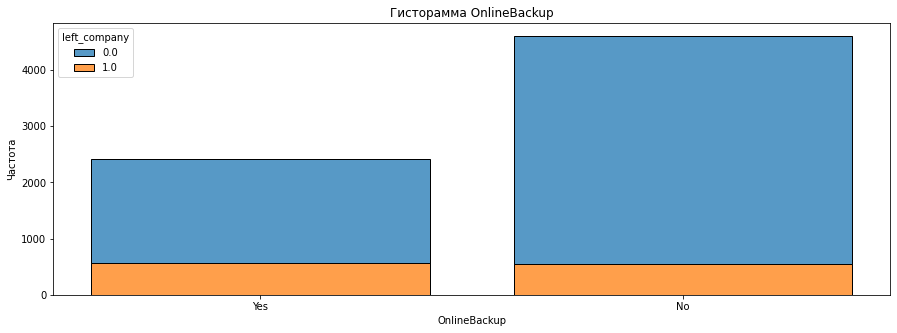

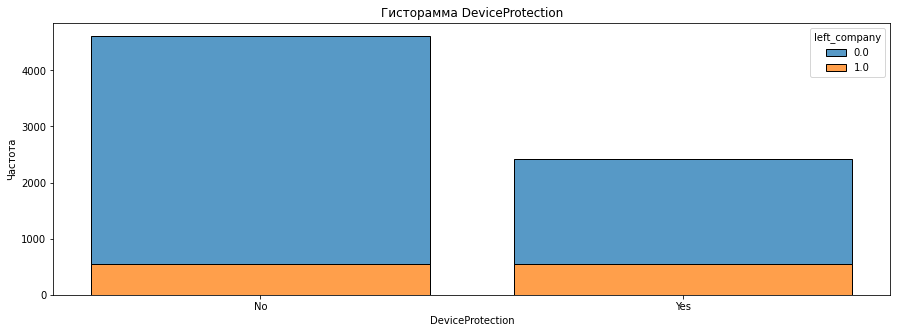

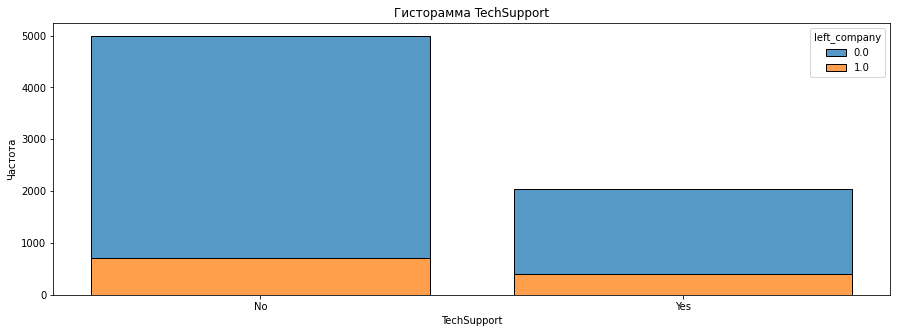

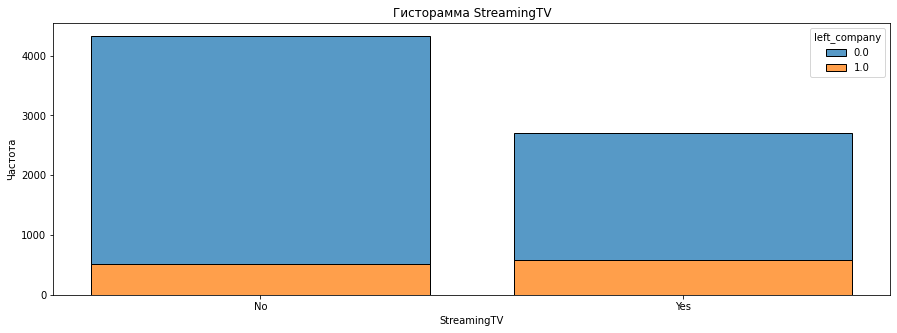

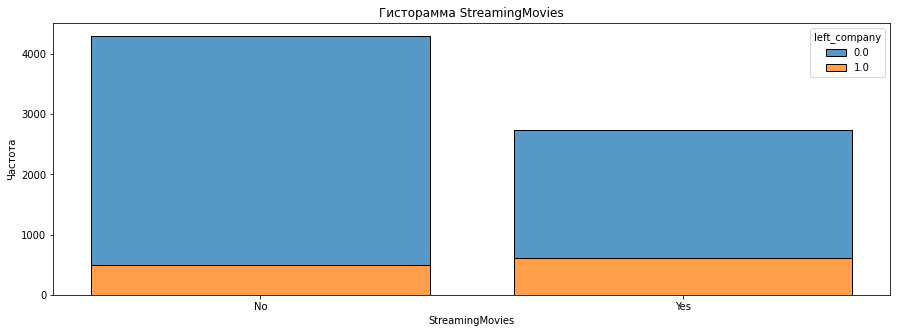

In [49]:
for i in ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    plt.figure(figsize=(15,5))
    sns.histplot(data=df, x=i,hue='left_company', multiple="stack", shrink=.8)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Выводы по гистограммам:

В целом, основными факторами оттока клиентов среди рассмотренных услуг являются тип интернет-подключения и наличие некоторых дополнительных опций (например, OnlineSecurity). Наиболее заметный отток демонстрируют пользователи Fiber optic, в то время как клиенты DSL и «No Internet Service» более склонны оставаться. Дополнительные сервисы (OnlineSecurity, OnlineBackup, DeviceProtection) влияют на отток лишь незначительно: даже при большем общем числе пользователей, не пользующихся ими, доля ушедших примерно одинакова в обоих сегментах.   Обобщённые выводы по влиянию рассматриваемых факторов (устройство защиты, техническая поддержка, использование услуг StreamingTV и StreamingMovies) на отток клиентов представляю ниже:

1. Использование устройства защиты (DeviceProtection)  

   • Доля ушедших и оставшихся клиентов приблизительно одинакова как в группе с устройством защиты, так и без него.  

   • Следовательно, наличие или отсутствие устройства защиты не является определяющим фактором оттока.

2. Наличие технической поддержки (TechSupport)  

   • Большая часть клиентов не пользуется техподдержкой (около 5000 человек) по сравнению с пользующимися (менее 1500 человек).  
   • Среди не пользующихся техподдержкой клиентов доля ушедших меньше доли оставшихся. Аналогично, среди пользующихся техподдержкой тоже больше оставшихся клиентов.  

   • В целом, наличие техподдержки само по себе не влечёт существенного увеличения или уменьшения оттока.

3. Услуга ТВ (StreamingTV)  

   • Существенно отличается общее количество пользователей, использующих и не использующих услугу (больше тех, кто не использует).  

   • Пропорция ушедших клиентов среди пользователей и непользователей StreamingTV на первый взгляд примерно одинакова.  

   • Отсутствие заметной разницы в доле ушедших указывает на то, что наличие услуг ТВ не является ключевым фактором при уходе.

4. Услуга StreamingMovies  

   • При наличии услуги StreamingMovies доля ушедших клиентов чуть выше, чем среди тех, кто не использует услугу.  

   • Однако большинство клиентов остаётся в компании в обеих группах, поэтому нельзя говорить о значительном влиянии этого фактора на отток.

Общий вывод:  
Ни один из рассмотренных факторов (устройство защиты, техподдержка, услуги  ТВ и видео) не даёт явного сигнала о повышенном оттоке: практически во всех случаях потери клиентов распределяются сравнительно равномерно между категориями «Да» и «Нет». Для более точного понимания причин оттока стоит учитывать дополнительные параметры (демографические данные, тарифы, уровень удовлетворённости услугами, общее качество обслуживания и т.п.).

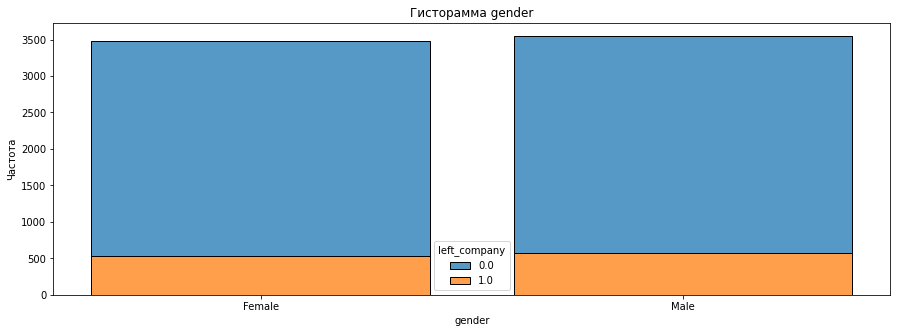

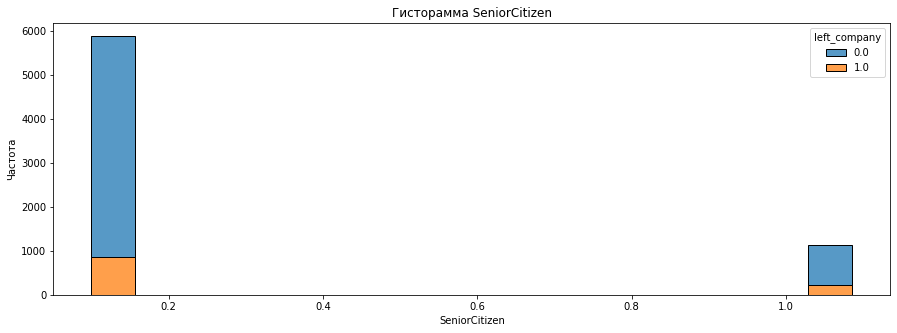

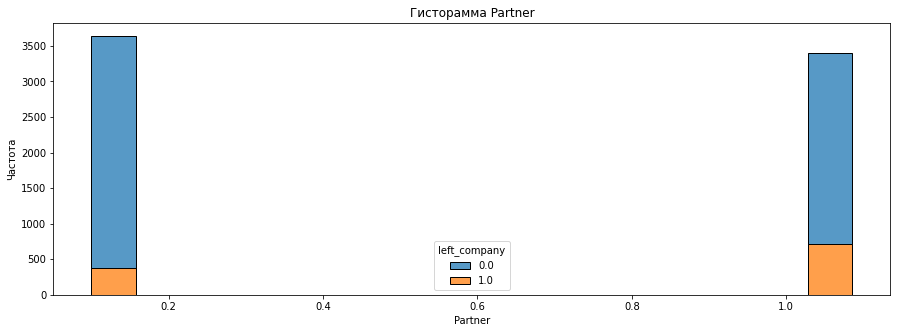

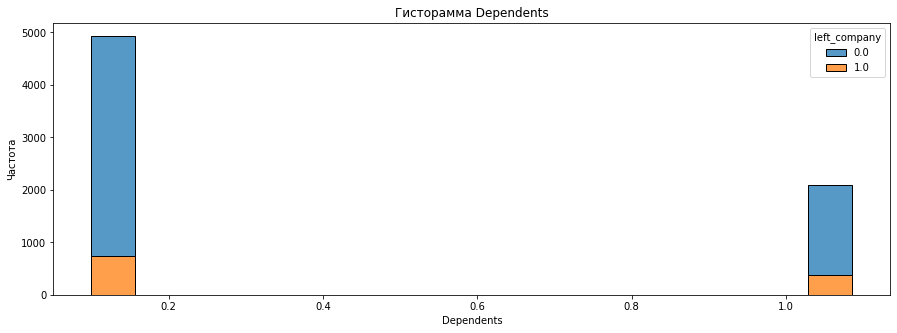

In [50]:
for i in ['gender','SeniorCitizen','Partner','Dependents']:
    plt.figure(figsize=(15,5))
    sns.histplot(data=df, x=i,hue='left_company', multiple="stack", shrink=.8)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Выводы из анализа гистограмм показывают, что:

1. Пол пользователей: Распределение мужчин и женщин  примерно одинаковое, и уровень "ухода" не зависит от пола. Пол не является значимым фактором для ухода.

2. Статус пенсионера клиентов: Большинство клиентов не являются пенсионерами, и хотя доля 'уходящих' среди обеих категорий примерно равна, абсолютное количество ушедших больше среди не пенсионеров.

3. Статус супруга : Как супруги, так и пользователи без статуса партнера в основном 'остаются', и уровень 'ухода' в обеих группах сопоставим. Статус партнера не влияет на уход.

В целом, ни пол, ни статус пенсионера, ни статус партнера не оказывают значительного влияния на уход клиентов из компании.

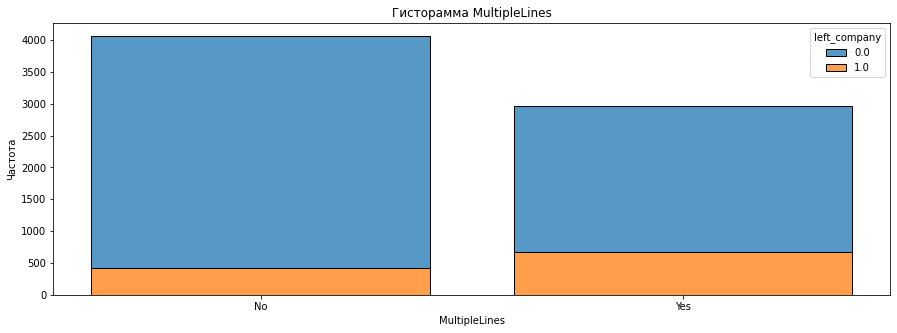

In [51]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='MultipleLines',hue='left_company', multiple="stack", shrink=.8)
plt.ylabel('Частота')
plt.xlabel('MultipleLines')
plt.title(f'Гисторамма MultipleLines')
plt.show()


Выводы по гистограммам:

Большинство клиентов, как с возможностью использования нескольких телефонных линий, так и без нее, не покинули компанию. Доля ушедших клиентов примерно одинакова в обеих категориях, но немного выше среди тех, кто не имел доступа к нескольким линиям. Таким образом, наличие или отсутствие возможности использования нескольких линий не оказывает значительного влияния на решение клиента о уходе из компании.

Подбираю данные для обучения модели и анализирую мультиколлинеарность признаков.

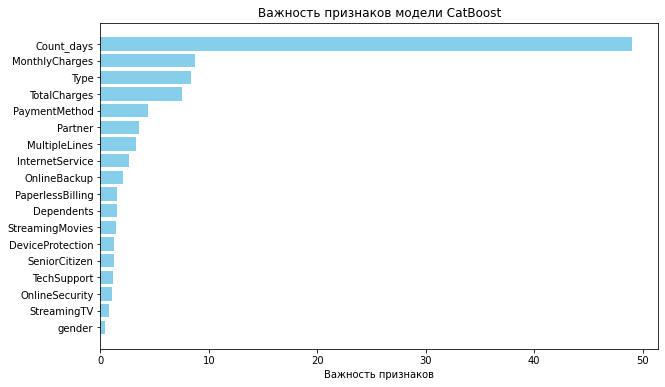

In [52]:
# создание экземпляра OrdinalEncoder, указывая столбцы с категориальными данными
final_data = df.iloc[:, 3:]
ce_ord = ce.OrdinalEncoder(cols=final_data.select_dtypes('object').columns)

# применение кодирования к данным
data = ce_ord.fit_transform(final_data)

# создание экземпляра классификатора CatBoost и обучение модели на данных
catboost = CatBoostClassifier(random_seed=42, silent=True)
catboost.fit(data.drop(['left_company'], axis=1), data.left_company)

# получение важности признаков модели CatBoost
feat_imp = catboost.get_feature_importance()

# создание DataFrame из значений важности признаков
importance_df = pd.DataFrame(feat_imp, index=data.drop(['left_company'], axis=1).columns, columns=['Важность признаков'])

# сортировка значений важности признаков
importance_df = importance_df.sort_values(by='Важность признаков', ascending=False)

# визуализация важности признаков с помощью Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(importance_df.index, importance_df['Важность признаков'], color='skyblue')
plt.xlabel('Важность признаков')
plt.title('Важность признаков модели CatBoost')
# инвертирую ось Y для лучшего отображения
plt.gca().invert_yaxis()  
plt.show()


На основе анализа важности признаков можно сделать вывод:
Наиболее значимыми признаками, оказывающими наибольшее влияние на предсказания модели, являются длина контракта (ContractLength) и количество дней (Count_days), которые имеют самые высокие значения важности. Это указывает на то, что эти два признака играют ключевую роль  для проекта, использованной в данном анализе.

Далее по значимости идут признаки, такие как тип (Type) и ежемесячные платежи (MonthlyCharges), которые также оказывают значительное влияние на модель.
В то время как такие признаки, как пол (gender) и наличие доступа в интернет (InternetService), имеют наименьшую важность, что может указывать на их меньшую значимость в контексте рассматриваемой задачи.

### Корреляция параметров phik

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'left_company', 'Count_days', 'SeniorCitizen', 'Partner', 'Dependents']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerID is large: 7032. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.
  warnings.warn(


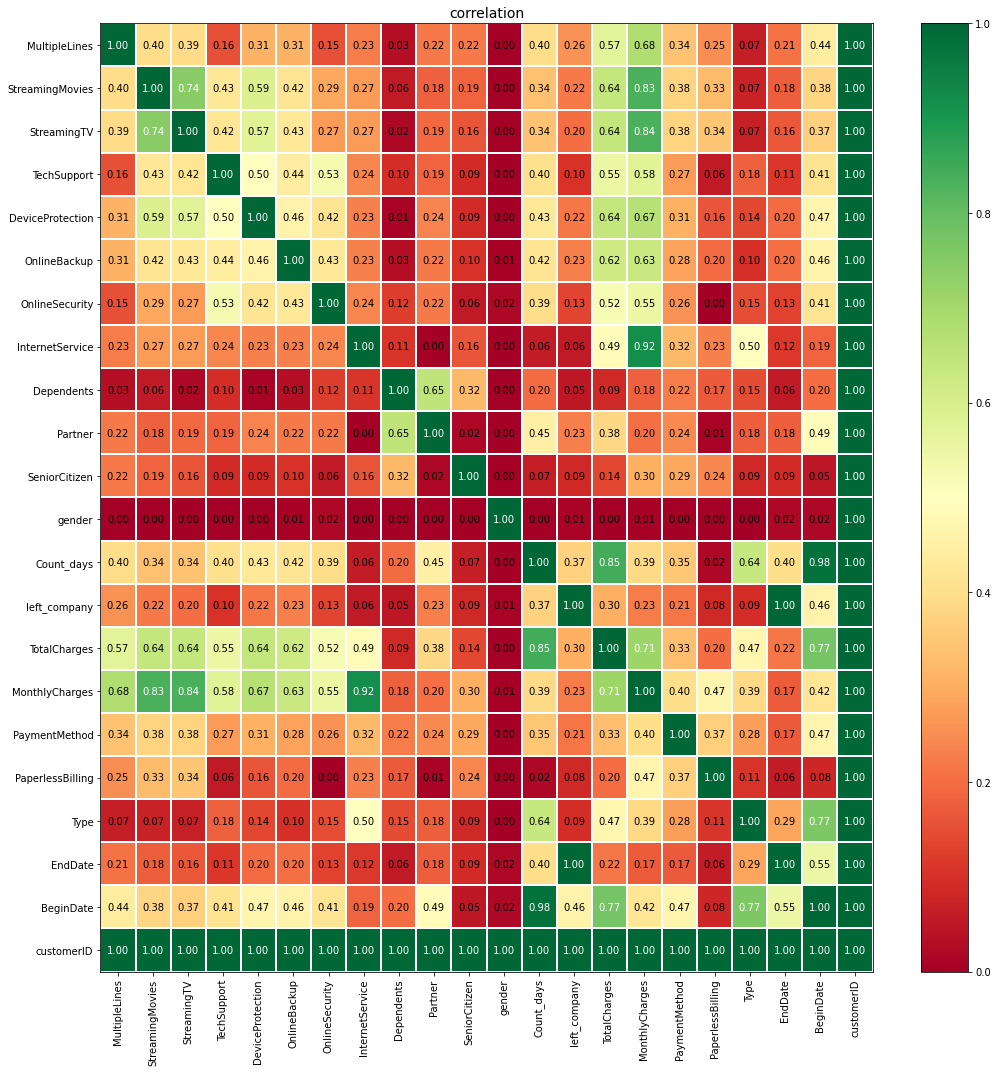

In [53]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    figsize=(15, 15)
)

plt.show()

На основе матрицы корреляции можно отметить следующее:  
• Сильная корреляция:  
  • StreamingTV и StreamingMovies (0.97) — вероятно, покупаются вместе.  
  • TechSupport, DeviceProtection, OnlineBackup и OnlineSecurity (0.90–0.95) — часто берут в комплексе.  
• Средняя корреляция:  
  • TotalCharges и MonthlyCharges (0.65), а также TotalCharges и ContractLength (0.52) — рост общих расходов совпадает с повышением ежемесячных платежей и длительности договора.  
  • left_company и ContractLength (0.37), MonthlyCharges (0.39) — клиенты чаще уходят при более длительном контракте и среднем уровне платежей.  
• Слабая/отсутствие корреляции:  
  • gender, SeniorCitizen, customerID — почти никак не связаны с остальными переменными.  
• Структура данных:  
  • customerID (уникальный идентификатор) и gender (пол) логично не влияют существенно на параметры использования услуг.  
Выводы помогают в дальнейшем анализе, прогнозе поведения клиентов и оптимизации пакетов услуг.

**ВЫВОД по разделу: Исследовательский анализ и предобработка данных объединённого датафрейма**

На основе проведенного исследовательского анализа объединенного датасета  можно сделать следующие выводы:

1. Объем и качество данных: Датасет содержит 7032 записи и 24 столбца, что позволяет рассчитывать на репрезентативность результатов. Большинство полей не имеют пропущенных значений. Пропуски были успешно заменены на значение '-1', что позволит избежать удаления значений и сохранить целостность анализа.

2. Целевой признак: Поле 'EndDate' является ключевым индикатором для определения того, разорвал ли пользователь договор с телекоммуникационной компанией. Наличие даты окончания договора свидетельствует о расторжении, в то время как ее отсутствие указывает на активный договор.

3. Исследовательский анализ данных: Анализ показал, что распределение пользователей по различным параметрам достаточно равномерное. Например, почти поровну клиентов с супругами и без, большинство предпочитает электронные счета, а лишь небольшая часть составляет пенсионеры. Среднемесячные платежи пользователей различаются в зависимости от типа подключения к интернету, причем клиенты с оптоволоконным подключением тратят больше всего.

4. Влияние типа подключения на отток клиентов: Данные показывают, что пользователи с оптоволоконным подключением имеют более высокие среднемесячные расходы и объемы трат, чем клиенты с подключением DSL или без интернета. Это может указывать на то, что высокая стоимость услуг приводит к большему числу расторжений среди клиентов с более низкими расходами.

5. Анализ категориальных признаков: Анализ указывает на необходимость улучшения программ удержания клиентов и изучения факторов их ухода. Рассмотренные аспекты, такие как защита, техподдержка и услуги потокового ТВ, не демонстрируют явной связи с оттоком клиентов — потери распределяются равномерно. Пол, пенсионный статус, партнерство не влияют на решение клиентов покинуть компанию. Также возможность использования нескольких линий связи не существенно влияет на их выбор.

6. Корреляция между переменными: Наблюдается высокая корреляция между стриминговыми сервисами (StreamingMovies и StreamingTV), что может говорить о том, что пользователи, использующие один из них, склонны подписываться и на другой. Это может быть полезной 
информацией для маркетинговых стратегий и предложения комбинированных услуг.

7. Анализа важности признаков: ключевыми факторами для предсказания оттока клиентов являются ContractLength, Count_days, MonthlyCharges и TotalCharges. В то же время, признаки OnlineSecurity и TechSupport имеют низкую важность, но их исключение из анализа может снизить информативность модели в определенных случаях.

8. Высокая корреляция между дополнительными услугами:

   • Действительно, высокая корреляция (~0.9) между такими услугами, как DeviceProtection, OnlineBackup и OnlineSecurity,StreamingTV и StreamingMovies  может указывать на то, что клиенты, заинтересованные в одной из этих услуг, склонны подключать и другие. Это может быть полезным для кросс-продаж и маркетинговых стратегий.  
   • Корреляция ~0.65 между TotalCharges и MonthlyCharges действительно может свидетельствовать о том, что рост общих расходов совпадает с повышением ежемесячных платежей и длительности договора.   
   • Признаки SeniorCitizen не показывают значимой корреляции с другими переменными. Это может говорить о том что эти факторы не оказывают значительного влияния на поведение клиентов в контексте анализа.

Данные изучены, полностью исследованы и готовы для дальнейшего обучения моделей машинного обучения.

## Подготовка данных

Перед тем как обучать модели, необходимо преобразовать данные, разделить данные на обучающую и тестовую выборки.

In [54]:
# Деление на выборки
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(['left_company'], axis=1), 
    data.left_company,
    test_size=0.25,
    random_state=100225,
    stratify=data.left_company
)

# Проверка размеров выборок
print("Размеры выборок:")
print(f"Обучающая выборка: {features_train.shape[0]} записей")
print(f"Тестовая выборка: {features_test.shape[0]} записей")



Размеры выборок:
Обучающая выборка: 5274 записей
Тестовая выборка: 1758 записей


**ВЫВОД по разделу: Подготовка данных**

Процесс разделения данных на обучающую и тестовую выборки выполнен успешно, что позволяет продолжить работу над моделью, используя обучающую выборку для обучения и тестовую для оценки её производительности.

## Обучение моделей машинного обучения

Для обучения возьму три модели:

-  LGBMClassifier 
-  CatBoostClassifier
-  RandomForestClassifier

Применю GridSearch для оптимизации гиперпараметров этих моделей.   
Для модели LGBM создам пайплайн.  

In [55]:
pipe_lgbm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lgbm', LGBMClassifier(random_state=100225,
                             objective='binary',
                             class_weight='balanced',
                             verbose=-1))  
])

lgbm_params = {
    'lgbm__max_depth': [2],
    'lgbm__n_estimators': [300],
    'lgbm__learning_rate': [0.6]
}


grid_search_lgbm = GridSearchCV(pipe_lgbm,
                                 lgbm_params, 
                                 verbose=3,
                                 cv=10,  
                                 n_jobs=-1,
                                 scoring='roc_auc')

grid_search_lgbm.fit(features_train, target_train)
best_score = grid_search_lgbm.best_score_
print(f"Best ROC AUC score: {best_score}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 1/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.895 total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 2/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.924 total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 3/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.926 total time=   0.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 4/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.906 total time=   0.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 5/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.913 total time=   0.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 6/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.912 total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 7/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.928 total time=   0.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 8/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.900 total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 9/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.846 total time=   0.7s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV 10/10] END lgbm__learning_rate=0.6, lgbm__max_depth=2, lgbm__n_estimators=300;, score=0.862 total time=   0.7s
Best ROC AUC score: 0.9011723706689316


Для оптимизации гиперпараметров в CatBoostClassifier я расширила сетку параметров, чтобы учесть больше вариантов настройки. В коде применяю GridSearchCV, что дает возможность осуществлять поиск по сетке гиперпараметров.Также добавила два дополнительных гиперпараметра: depth и learning_rate, чтобы сделать процесс подбора более гибким. Этот подход поможет найти более подходящие настройки модели для нашей задачи.

In [57]:
# инициализация модели CatBoost
catboost = CatBoostClassifier(loss_function='Logloss', random_seed=42, silent=True)

# сетка гиперпараметров для поиска
catboost_params = {
    'depth': [2, 4, 6],  # добавила варианты для глубины дерева
    'iterations': [500],  
    'learning_rate': [0.1, 0.5, 0.01],  # добавила варианты для learning rate
    'l2_leaf_reg': [1, 3, 5],  # добавила варианты для регуляризации L2
}

# инициализация GridSearchCV
grid_search_catboost = GridSearchCV(
    catboost,
    catboost_params,
    verbose=3,
    cv=10,
    n_jobs=-1,
    scoring='roc_auc'
)

# обучение модели с поиском по сетке
grid_search_catboost.fit(features_train, target_train)

# вывод лучшего результата
print("Лучший показатель ROC-AUC:", grid_search_catboost.best_score_)
print("Лучшие гиперпараметры:", grid_search_catboost.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[CV 1/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.898 total time=   1.3s
[CV 2/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.920 total time=   1.5s
[CV 3/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.913 total time=   1.5s
[CV 4/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.891 total time=   1.3s
[CV 5/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.904 total time=   1.5s
[CV 6/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.901 total time=   1.3s
[CV 7/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.916 total time=   1.5s
[CV 8/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.883 total time=   1.2s
[CV 9/10] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.1;, score=0.828 total time=

In [58]:
rfc = RandomForestClassifier(class_weight='balanced',
                             bootstrap=True,
                             random_state=42)

rfc_params = {
     'n_estimators': [140],
     'max_depth': [8],
     'criterion': ['entropy'],
     'max_features': ['sqrt']

}

grid_search_rfc = GridSearchCV(rfc,
                                   rfc_params, 
                                   verbose=3,
                                   cv=10,
                                   n_jobs=-1,
                                  scoring='roc_auc')


grid_search_rfc.fit(features_train, target_train)
grid_search_rfc.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.816 total time=   0.7s
[CV 2/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.873 total time=   0.7s
[CV 3/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.846 total time=   0.7s
[CV 4/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.835 total time=   0.7s
[CV 5/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.817 total time=   0.8s
[CV 6/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.835 total time=   0.7s
[CV 7/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.842 total time=   0.7s
[CV 8/10] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=140;, score=0.822 total time=   0.7s
[CV 9/10] END crite

0.8235138126071275

In [59]:
# результаты обучения моделей заношу в таблицу
data = {
    'model': ['LGBMClassifier', 'CatBoostClassifier', 'RandomForestClassifier'],
    'AUC-ROC': [0.9011723706689316, 0.9260864576271505, 0.8235138126071275] 
}

# Создание DataFrame
df = pd.DataFrame(data)

# Вывожу таблицу
print(tabulate(df, headers='keys', tablefmt='grid'))

+----+------------------------+-----------+
|    | model                  |   AUC-ROC |
+====+========================+===========+
|  0 | LGBMClassifier         |  0.901172 |
+----+------------------------+-----------+
|  1 | CatBoostClassifier     |  0.926086 |
+----+------------------------+-----------+
|  2 | RandomForestClassifier |  0.823514 |
+----+------------------------+-----------+


**Вывод по разделу: Обучение моделей машинного обучения**

В результате обучения моделей  по результатам значений AUC-ROC для различных моделей можно сделать следующие выводы:

1. CatBoostClassifier (0.926086): Эта модель показывает наилучший результат среди всех представленных. Значение AUC-ROC близкое к 1 указывает на то, что модель хорошо различает положительные и отрицательные классы. Это делает CatBoostClassifier наиболее предпочтительным выбором для нашего проекта.

2. LGBMClassifier (0.901172): Эта модель также демонстрирует хороший результат, хотя и немного уступает CatBoostClassifier. Значение AUC-ROC выше 0.9 свидетельствует о том, что LGBMClassifier также является надежным вариантом, но может быть менее эффективен в сравнении с CatBoost.

3. RandomForestClassifier (0.823514): Эта модель имеет значительно более низкое значение AUC-ROC по сравнению с двумя предыдущими. Значение ниже 0.85 может указывать на то, что RandomForestClassifier не так хорошо справляется с задачей классификации в проекте.

Рекомендуется использовать CatBoostClassifier, а LGBMClassifier может быть хорошей альтернативой. RandomForestClassifier, хотя и полезен в некоторых случаях, в данном проекте показывает менее удовлетворительные результаты.

## Выбор лучшей модели

In [60]:
predict_proba = grid_search_catboost.predict_proba(features_test)[:, 1]

In [61]:
roc_auc_score(target_test, predict_proba)

0.9417617850793845

Полученный результат AUC-ROC  0.942 является очень хорошим показателем. Наша модель CatBoost хорошо различает положительные и отрицательные классы в тестовом наборе данных. 

1. Высокая точность: Значение AUC-ROC близкое к 1 показывает, что модель правильно классифицирует большинство примеров.

2. Хорошая способность различать классы: Значение 0.942 говорит о том, что модель хорошо отделяет положительные классы от отрицательных, что важно, особенно если классы неравномерно распределены.

Результат показывает, что модель хорошо справляется с задачей классификации на тестовых данных.

In [62]:
# напишу функция для построения ROC-кривой
def draw_ROC(target, predict_proba):
    fpr, tpr, thresholds = roc_curve(target, predict_proba, pos_label=1)
    plt.figure(figsize=(12, 10))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-график')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show() 

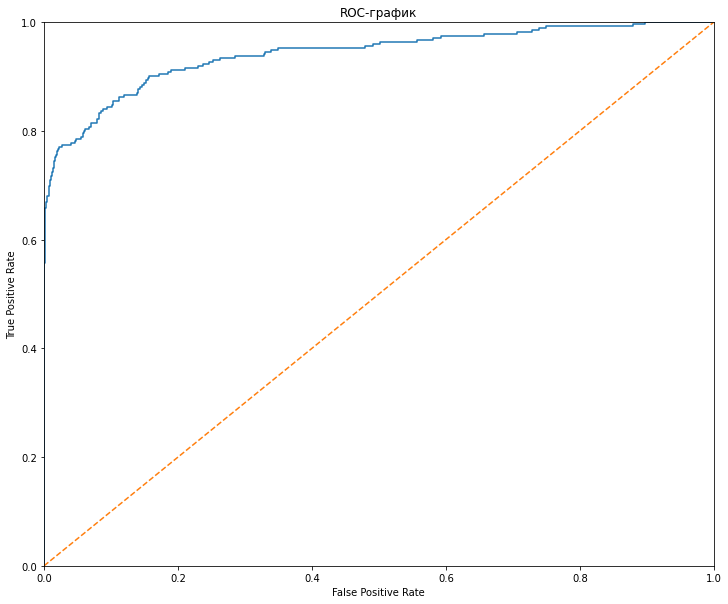

In [63]:
draw_ROC(target_test, predict_proba)

Из анализа графика можно сделать следующие выводы:

1. Качество модели:

   • Кривая значительно выше диагональной линии "случайного угадывания" (оранжевой пунктирной линии), что свидетельствует о том, что модель имеет достаточно хорошее качество.  
   • Чем дальше ROC-кривая от диагонали и ближе к верхнему левому углу, тем лучше модель.  

2. Темпы срабатываний:

   • Модель имеет высокий уровень истинно положительных срабатываний при относительно низких уровнях ложноположительных ошибок, что является признаком хорошей модели.

В целом, график указывает на высокое качество оценки модели для задач классификации.

In [64]:
# предсказание значений на тестовом наборе данных (features_test)
predicted_test = grid_search_catboost.predict(features_test) 

In [65]:
accuracy_score(target_test, predicted_test)

0.9448236632536974

Text(0.5, 1.05, 'Матрица ошибок')

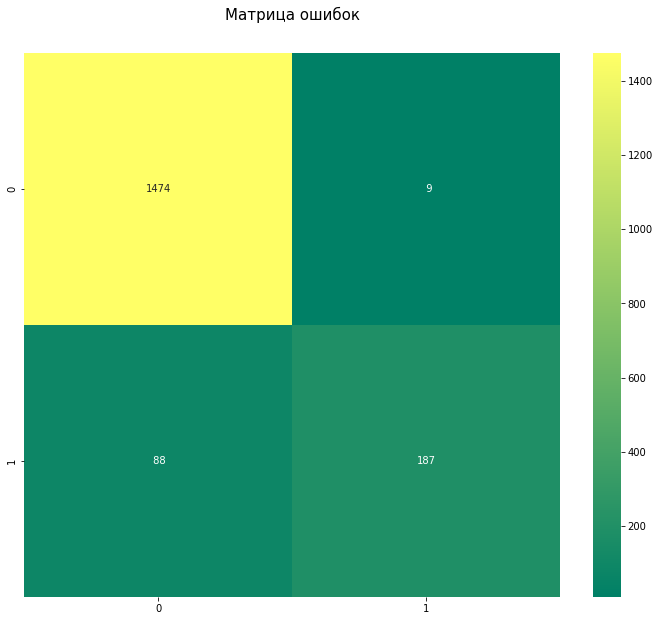

In [66]:
# построю матрицу ошибок
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(target_test, predicted_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Матрица ошибок', y=1.05, size=15)

Матрица ошибок показывает, как хорошо работает классификационная модель.

Из этих данных можно сделать следующие выводы:

Модель демонстрирует высокую точность в предсказаниях, однако её склонность к ложным негативным результатам указывает на то, что она более эффективно идентифицирует тех, кто перестанет быть абонентом оператора связи, чем тех, кто останется. Это может свидетельствовать о необходимости доработки модели для улучшения её способности предсказывать оставшихся пользователей.

Рассмотрю модель Dummy и проверю, не делала ли наша модель случайных предсказаний.

In [67]:
# создаю экземпляр классификатора DummyClassifier со стратегией 'stratified' для предсказания
dummy_model = DummyClassifier(strategy='stratified')
# обучаю модель на обучающем наборе данных (features_train и target_train)
dummy_model.fit(features_train,target_train)
# получаю вероятность предсказаний для тестового набора данных
dummy_pred_proba = dummy_model.predict_proba(features_test)[:, 1]
dummy_pred = dummy_model.predict(features_test)

In [68]:
# вычисляю AUC ROC для оценки качества модели.
roc_auc_score(target_test, dummy_pred_proba)

0.4965303745479066

In [69]:
accuracy_score(target_test, dummy_pred)

0.735494880546075

Наблюдаемая разница в оценках между моделью-эталоном (dummy) и нашими моделями свидетельствует о том, что последние способны делать предсказания, основанные на закономерностях в данных, а не случайным образом. Это подтверждает их эффективность и указывает на наличие значимой информации, используемой для прогнозирования.

**ВЫВОД по разделу: Выбор лучшей модели**

На основании анализа результатов модели лучшей CatBoost можно сделать следующие выводы:

1. Высокая эффективность модели: Значение AUC-ROC 0.926 указывает на то, что модель успешно различает положительные и отрицательные классы. Это говорит о высоком уровне точности в классификации, что особенно важно в случаях, когда классы могут быть неравномерно распределены.

2. Качество предсказаний: График ROC подтверждает высокое качество модели, так как кривая значительно удалена от диагонали случайного угадывания. Чем ближе кривая к верхнему левому углу, тем лучше модель справляется с задачей.

3. Уровень срабатываний: Модель демонстрирует высокий уровень истинно положительных срабатываний при низком уровне ложноположительных ошибок. Это является дополнительным индикатором её надежности.

4. Необходимость доработки: Хотя модель показывает хорошие результаты в идентификации пользователей, которые уйдут от оператора связи, она имеет склонность к ложным негативным результатам. Это указывает на необходимость улучшения модели для более точного предсказания оставшихся пользователей.

5. Сравнение с моделью Dummy: Наблюдаемая разница в оценках между моделью CatBoost и моделью-эталоном (dummy) подтверждает, что CatBoost использует закономерности в данных для предсказаний, а не делает случайные прогнозы. Это подчеркивает её эффективность и наличие значимой информации для прогнозирования.

В целом, результаты анализа свидетельствуют о том, что модель CatBoost хорошо справляется с задачей классификации, но требует дальнейшей доработки для повышения её способности к предсказанию оставшихся пользователей.

## Общий вывод и рекомендации заказчику

В ходе выполнения проекта была проведена комплексная работа по обучению и выбору наиболее эффективной модели для прогнозирования оттока клиентов. Основным критерием выбора модели стала метрика AUC-ROC, которая должна была превышать 0.85.

Предобработка данных:

• Каждая из таблиц была тщательно предобработана.

• Объединенная таблица также прошла этап предобработки.

• Все пропущенные значения были корректно обработаны.

Исследовательский анализ данных:

• Анализировались корреляции между различными признаками и целевой переменной.

• Проведен анализ данных для категориальных признаков.

• Построена матрица корреляций phik для более глубокого понимания взаимосвязей.

Обучение моделей машинного обучения:

• Были протестированы несколько моделей:

  • LGBMClassifier

  • CatBoostClassifier

  • RandomForestClassifier

• Качество работы каждой модели было проанализировано, и наилучшие результаты показала модель CatBoostClassifier с метрикой AUC-ROC равной 0.926086. 

Тестирование модели CatBoostClassifier:

• Построена матрица ошибок для оценки производительности модели.

• Проведен анализ важности признаков.

• Создан и проанализирован график важности признаков, что позволяет понять, какие факторы наиболее влияют на предсказания.

▎Рекомендации:

Рекомендуется внедрить модель CatBoostClassifier. Эта модель будет эффективной для прогнозирования расторжения клиентских договоров в телекоммуникационной компании, предоставляющей услуги связи. Рекомендуется также регулярно обновлять модель с новыми данными и пересматривать параметры для поддержания её актуальности и эффективности.

Итоговые метрики качества составили:

• ROC AUC: 0.93   
• Лучшие гиперпараметры: {'depth': 2, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.5}    
• Точность модели: 0.94    
Это удовлетворяет критериям оценки нашего проекта.